In [1]:
import os
import networkx as nx
import matplotlib.pyplot as plt

os.environ["DGLBACKEND"] = "pytorch"
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


## Loading Data


In [2]:
# Generate a synthetic dataset with 10000 graphs, ranging from 10 to 500 nodes.
dataset = dgl.data.GINDataset("PROTEINS", self_loop=True)

The dataset is a set of graphs, each with node features and a single
label. One can see the node feature dimensionality and the number of
possible graph categories of ``GINDataset`` objects in ``dim_nfeats``
and ``gclasses`` attributes.




(Graph(num_nodes=42, num_edges=204,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), tensor(0))


<Figure size 1440x1440 with 0 Axes>

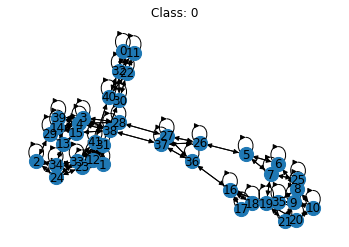

In [19]:
def plot_data(n):
    print(dataset[n])
    graph, label = dataset[n]
    plt.figure(figsize=(20,20))
    fig, ax = plt.subplots()
    nx.draw(graph.to_networkx(), ax=ax, with_labels=True,node_size=200)
    ax.set_title('Class: {:d}'.format(label))
    plt.show()
    
plot_data(0)

##  Data Loader


In [3]:
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=5, drop_last=False
)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=5, drop_last=False
)

As each element in ``dataset`` has a graph and a label, the
``GraphDataLoader`` will return two objects for each iteration. The
first element is the batched graph, and the second element is simply a
label vector representing the category of each graph in the mini-batch.
Next, we’ll talked about the batched graph.

A Batched Graph in DGL
----------------------

In each mini-batch, the sampled graphs are combined into a single bigger
batched graph via ``dgl.batch``. The single bigger batched graph merges
all original graphs as separately connected components, with the node
and edge features concatenated. This bigger graph is also a ``DGLGraph``
instance (so you can
still treat it as a normal ``DGLGraph`` object as in
`here <2_dglgraph.ipynb>`__). It however contains the information
necessary for recovering the original graphs, such as the number of
nodes and edges of each graph element.




In [19]:
batched_graph, labels = batch
print(
    "Number of nodes for each graph element in the batch:",
    batched_graph.batch_num_nodes(),
)
print(
    "Number of edges for each graph element in the batch:",
    batched_graph.batch_num_edges(),
)

# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
print("The original graphs in the minibatch:")
print(graphs)

Number of nodes for each graph element in the batch: tensor([31, 43, 84, 15, 11])
Number of edges for each graph element in the batch: tensor([153, 235, 346,  69,  53])
The original graphs in the minibatch:
[Graph(num_nodes=31, num_edges=153,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=43, num_edges=235,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=84, num_edges=346,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=15, num_edges=69,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=11, num_edges=53,
      ndata_schemes={'label': Scheme(shape=(), dtype=to

 SAGEConve Layers
-------------------------------

This model is consisting of two **GraphSAGE layers(from DGL Library)**. GraphSAGE was developed by Hamilton, Ying, and Leskovec (2017). Graph SAGE (SAmple and aggreGatE) provides an inductive approach to learning a low dimensional embedding of nodes in graphs, similar to NLP tasks. GraphSAGE operates iteratively in two stages,**aggregate and update** like other GNN. Its aggregate and update similar to other message passing layers and computed as other models. GraphSAGE is computationally efficient as it only requires a fixed-size neighborhood sampling instead of considering all nodes in the graph. 

In [4]:
from dgl.nn import SAGEConv


# ----------- 2. create model -------------- #
# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats,  num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata["h"] = h
        return dgl.mean_nodes(g, "h")

In [5]:
# Create the model with given dimensions
model_SAGE = GraphSAGE(dataset.dim_nfeats, 16, dataset.gclasses)
optimizer = torch.optim.Adam(model_SAGE.parameters(), lr=0.001)



epoch_losses = []
for epoch in range(100):
    epoch_loss = 0
    for iter, (batched_graph, labels) in enumerate(train_dataloader):
    #for batched_graph, labels in train_dataloader:
        pred = model_SAGE(batched_graph, batched_graph.ndata["attr"].float())
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    if epoch%10==0 :
        print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)



Epoch 0, loss 0.0064
Epoch 10, loss 0.0026
Epoch 20, loss 0.0043
Epoch 30, loss 0.0023
Epoch 40, loss 0.0031
Epoch 50, loss 0.0018
Epoch 60, loss 0.0019
Epoch 70, loss 0.0029
Epoch 80, loss 0.0026
Epoch 90, loss 0.0019


In [8]:
def accuracy(data):
    num_correct = 0
    num_tests = 0
    for batched_graph, labels in data:
        pred = model_SAGE(batched_graph, batched_graph.ndata["attr"].float())
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)
        return num_correct / num_tests

print("Train accuracy:", accuracy(train_dataloader))
print("Test accuracy:", accuracy(test_dataloader))

Train accuracy: 0.8
Test accuracy: 0.0


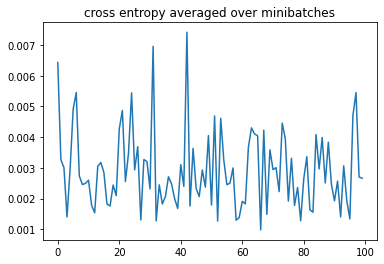

In [9]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()